# Veštačke neuronske mreže - projekat
* Dataset: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
* Klasifikacija zvezda, galaksija i kvazara

Features:
* obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* alpha = Right Ascension angle (at J2000 epoch)
* delta = Declination angle (at J2000 epoch)
* u = Ultraviolet filter in the photometric system
* g = Green filter in the photometric system
* r = Red filter in the photometric system
* i = Near Infrared filter in the photometric system
* z = Infrared filter in the photometric system
* run_ID = Run Number used to identify the specific scan
* rereun_ID = Rerun Number to specify how the image was processed
* cam_col = Camera column to identify the scanline within the run
* field_ID = Field number to identify each field
* spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
* class = object class (galaxy, star or quasar object)
* redshift = redshift value based on the increase in wavelength
* plate = plate ID, identifies each plate in SDSS
* MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
* fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from copy import deepcopy
from keras import callbacks

In [2]:
dataframe = pd.read_csv("../dataset/star_classification.csv")
print(dataframe.shape)
dataframe.head(10)


(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [3]:
dataframe["obj_ID"].nunique()

78053

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
print("Number Of Rows In The Original DataFrame:", len(dataframe))
print("Number Of Rows After Deduping:", len(dataframe.drop_duplicates()))

dataframe.sort_values("obj_ID", inplace=True)

dataframe.drop_duplicates(subset="obj_ID",
                     keep="first", inplace=True)

dataframe.shape

Number Of Rows In The Original DataFrame: 100000
Number Of Rows After Deduping: 100000


(78053, 18)

In [6]:
def get_one_value_cols(df):
    to_drop = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            to_drop.append(col)
    print(to_drop)
    return to_drop


dataframe.drop(get_one_value_cols(dataframe), axis=1, inplace=True)

['rerun_ID']


In [7]:
dataframe.drop("obj_ID", inplace=True, axis=1)

In [8]:
print(dataframe.shape)
dataframe.head(10)

(78053, 16)


,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
44221,54.555776,0.223247,22.19868,19.84683,18.37413,17.12478,16.43615,109,4,133,1.708153e+18,STAR,-0.000108,1517,52934,594
44096,54.683424,0.216919,20.79859,19.54183,19.04607,18.82743,18.74658,109,4,134,3.553454e+18,STAR,-0.000063,3156,54792,413
25590,57.047052,0.084304,19.46874,18.18264,17.59063,17.26436,16.95295,109,4,149,1.721602e+18,GALAXY,0.036167,1529,52930,366
25023,57.391204,0.224050,22.39327,21.63896,20.07250,19.42778,19.03903,109,4,152,1.399623e+18,GALAXY,0.246584,1243,52930,472
25369,57.428936,0.073067,22.02452,20.92500,19.74058,19.23929,18.84511,109,4,152,1.838730e+18,GALAXY,0.361637,1633,52998,493
26312,57.509642,0.067161,21.90292,19.43848,18.09329,17.61892,17.06034,109,4,153,1.721626e+18,GALAXY,0.130619,1529,52930,453
45488,57.647253,0.030695,19.73725,19.48620,19.04919,18.85514,18.79748,109,4,153,1.398504e+18,QSO,1.429148,1242,52901,494
25694,58.038383,0.117742,22.44247,20.96329,20.00247,19.47096,19.38536,109,4,156,1.838759e+18,GALAXY,0.235817,1633,52998,598
45878,58.355163,0.079549,24.50392,21.89720,21.12630,20.79458,20.36792,109,4,158,1.398539e+18,QSO,6.449718,1242,52901,624
25944,58.923318,0.051249,23.43689,22.50598,20.85043,20.05530,19.59501,109,4,162,1.399665e+18,GALAXY,0.317386,1243,52930,625


C:\Users\PC\AppData\Local\Temp\ipykernel_3168\2269040555.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataframe.corr(),annot = True,fmt = ".2f",cbar = True)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'alpha'),
  Text(0, 1.5, 'delta'),
  Text(0, 2.5, 'u'),
  Text(0, 3.5, 'g'),
  Text(0, 4.5, 'r'),
  Text(0, 5.5, 'i'),
  Text(0, 6.5, 'z'),
  Text(0, 7.5, 'run_ID'),
  Text(0, 8.5, 'cam_col'),
  Text(0, 9.5, 'field_ID'),
  Text(0, 10.5, 'spec_obj_ID'),
  Text(0, 11.5, 'redshift'),
  Text(0, 12.5, 'plate'),
  Text(0, 13.5, 'MJD'),
  Text(0, 14.5, 'fiber_ID')])

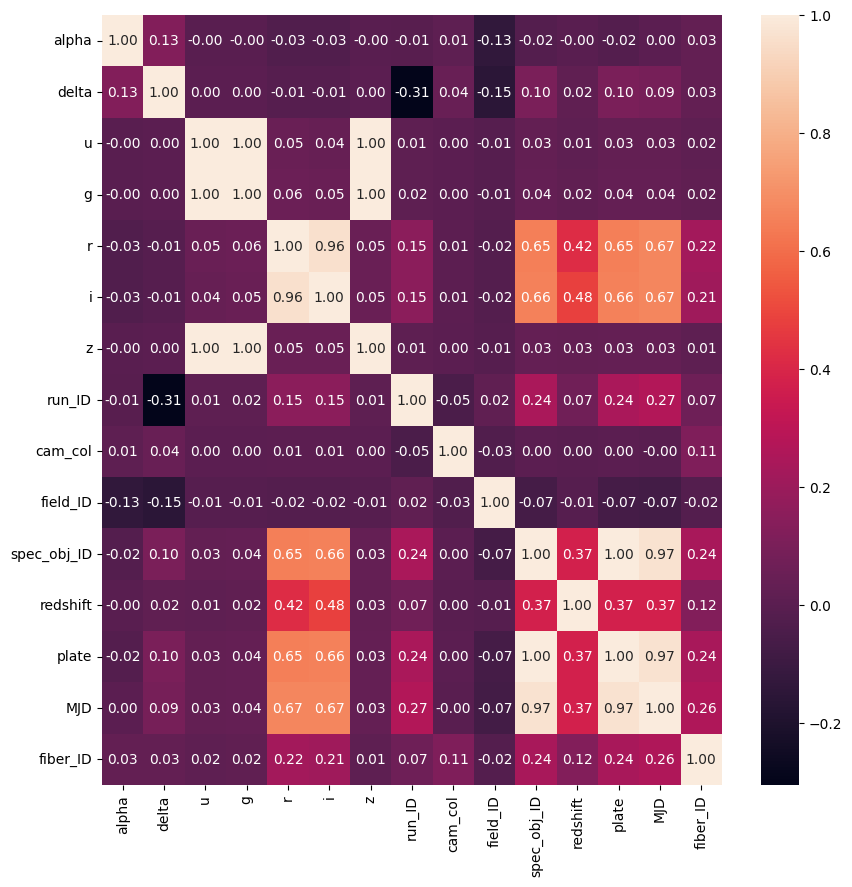

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(dataframe.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)

<AxesSubplot: ylabel='class'>

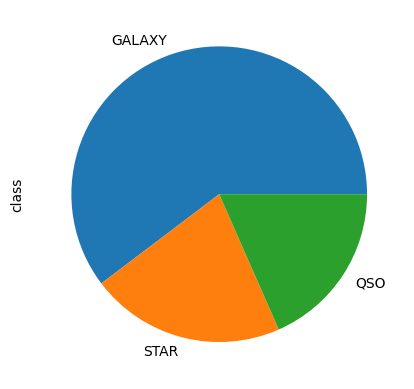

In [10]:
dataframe['class'].value_counts().plot(kind='pie')

In [11]:
one_hot = LabelBinarizer()

def df_one_hot(df, columns):
    tmp = pd.DataFrame()
    for col in columns:
        res = one_hot.fit_transform(df[col])
        for val in range(0, len(res[0])):
            new_col = res[:, val]
            tmp_col = pd.DataFrame(
                {col + '(' + str(one_hot.classes_[val])+')': new_col})
            tmp = pd.concat((tmp, tmp_col), axis=1)
    return pd.concat((df.reset_index(drop=True), tmp.reset_index(drop=True)), axis=1, join='inner')

In [12]:
one_coded = ['class']

dataframe_enc = dataframe.copy(deep=True)

dataframe_enc = df_one_hot(dataframe_enc, one_coded)
dataframe_enc.drop(one_coded, axis=1, inplace=True)

print(dataframe_enc.shape)
dataframe_enc.head(10)

(78053, 18)


,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class(GALAXY),class(QSO),class(STAR)
0,54.555776,0.223247,22.19868,19.84683,18.37413,17.12478,16.43615,109,4,133,1.708153e+18,-0.000108,1517,52934,594,0,0,1
1,54.683424,0.216919,20.79859,19.54183,19.04607,18.82743,18.74658,109,4,134,3.553454e+18,-0.000063,3156,54792,413,0,0,1
2,57.047052,0.084304,19.46874,18.18264,17.59063,17.26436,16.95295,109,4,149,1.721602e+18,0.036167,1529,52930,366,1,0,0
3,57.391204,0.224050,22.39327,21.63896,20.07250,19.42778,19.03903,109,4,152,1.399623e+18,0.246584,1243,52930,472,1,0,0
4,57.428936,0.073067,22.02452,20.92500,19.74058,19.23929,18.84511,109,4,152,1.838730e+18,0.361637,1633,52998,493,1,0,0
5,57.509642,0.067161,21.90292,19.43848,18.09329,17.61892,17.06034,109,4,153,1.721626e+18,0.130619,1529,52930,453,1,0,0
6,57.647253,0.030695,19.73725,19.48620,19.04919,18.85514,18.79748,109,4,153,1.398504e+18,1.429148,1242,52901,494,0,1,0
7,58.038383,0.117742,22.44247,20.96329,20.00247,19.47096,19.38536,109,4,156,1.838759e+18,0.235817,1633,52998,598,1,0,0
8,58.355163,0.079549,24.50392,21.89720,21.12630,20.79458,20.36792,109,4,158,1.398539e+18,6.449718,1242,52901,624,0,1,0
9,58.923318,0.051249,23.43689,22.50598,20.85043,20.05530,19.59501,109,4,162,1.399665e+18,0.317386,1243,52930,625,1,0,0


In [13]:
to_plot=[x for x in dataframe_enc.columns if '(' not in x ]
dataframe_enc[to_plot].describe()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,78053.000000,7.805300e+04,78053.000000,78053.00000,78053.000000,78053.000000
mean,179.898667,24.145389,22.029617,20.570453,19.692760,19.116347,18.664406,4522.867731,3.471974,184.751067,5.838183e+18,0.579555,5185.23789,55631.038025,451.139943
std,95.575776,19.407201,35.940781,35.922542,1.854957,1.749620,35.900177,1995.362796,1.587801,144.659150,3.283751e+18,0.732004,2916.54101,1776.073153,273.843279
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,1.000000,11.000000,2.995191e+17,-0.009971,266.00000,51608.000000,1.000000
25%,129.127005,6.243679,20.408320,19.047120,18.221630,17.807460,17.530520,3180.000000,2.000000,82.000000,2.971404e+18,0.059217,2639.00000,54474.000000,221.000000
50%,182.972322,23.270369,22.301980,21.190800,20.182550,19.438880,19.029220,4263.000000,3.000000,147.000000,5.644186e+18,0.439594,5013.00000,55893.000000,434.000000
75%,235.670246,39.353276,23.787110,22.181640,21.079790,20.411760,19.911710,5636.000000,5.000000,241.000000,8.313894e+18,0.699740,7384.00000,56772.000000,652.000000
max,359.999810,83.000519,32.781390,30.607000,29.571860,30.250090,29.383740,8162.000000,6.000000,989.000000,1.412693e+19,7.011245,12547.00000,58932.000000,1000.000000


<AxesSubplot: >

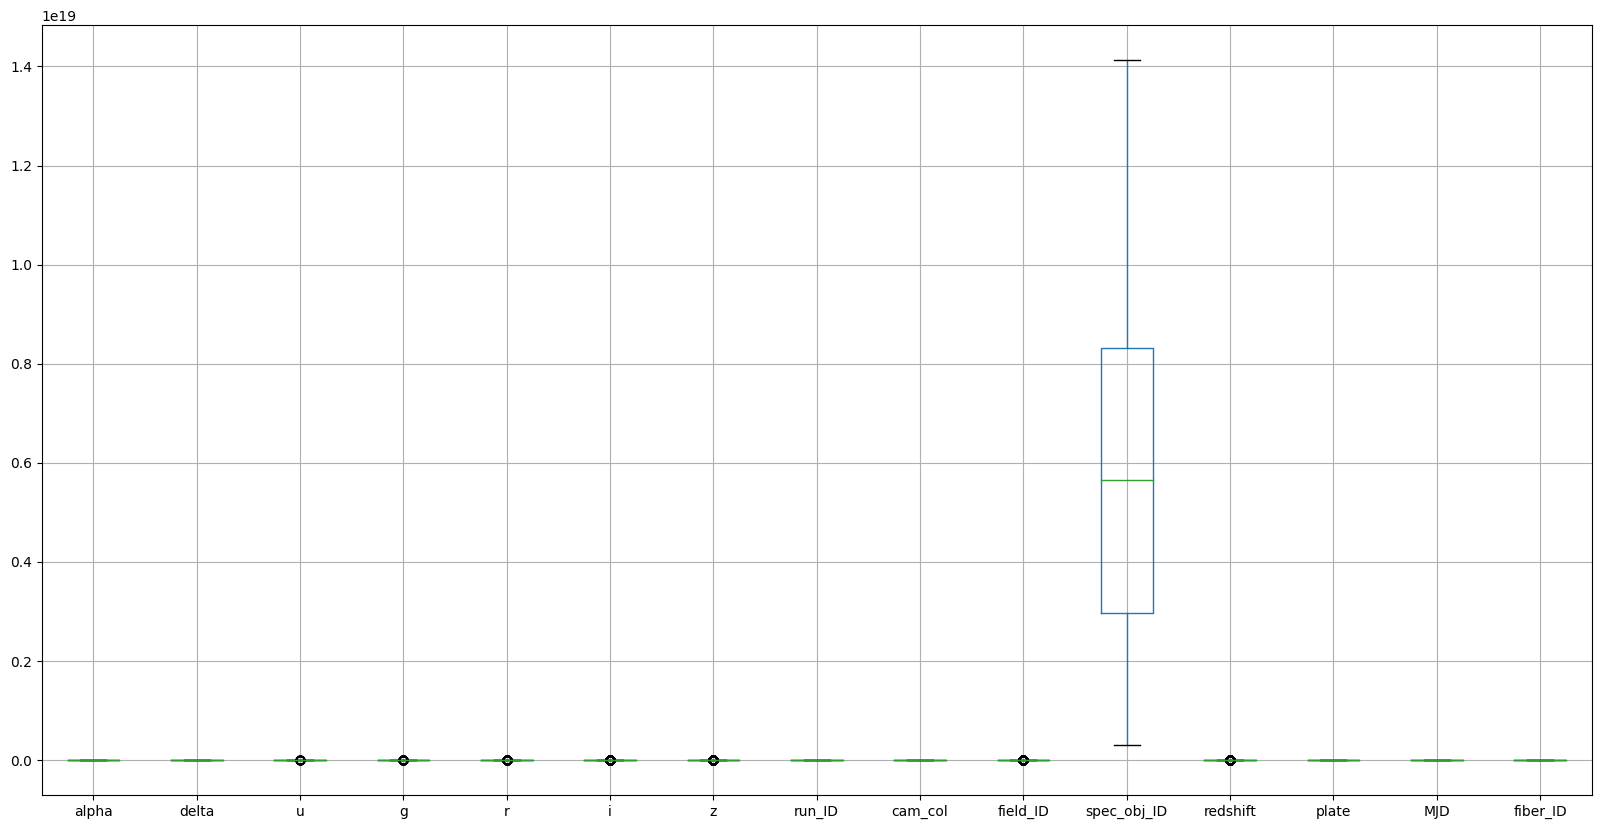

In [14]:
dataframe_enc.boxplot(column=to_plot, figsize=(20,10))

In [15]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler

In [16]:
def standardize(df,to_scale):
    scaler = MinMaxScaler()
    to_transform=df.drop([x for x in df.columns if x not in to_scale], axis=1)
    scaled = pd.DataFrame(scaler.fit_transform(to_transform))
    new_df = df.copy(deep=True)
    for index,col in enumerate(to_scale):
        new_df[col]=scaled[index]
    new_df.dropna(inplace=True)
    return new_df

def remove_outliers(df, cols, factor=0.1):
    standard=standardize(df, cols)
    outlier_detector = EllipticEnvelope(contamination=factor)
    outlier_detector.fit(standard)
    outlier_array= outlier_detector.predict(standard)
    to_drop=[]
    for index,x in enumerate(outlier_array):
        if x==-1:
            to_drop.append(index)

    standard.drop(standard.index[to_drop],inplace=True)
    return standardize(standard, cols)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-196.780702974095590 > -197.116819032764795). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-196.995807730170952 > -200.133780448733830). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-package

<AxesSubplot: >

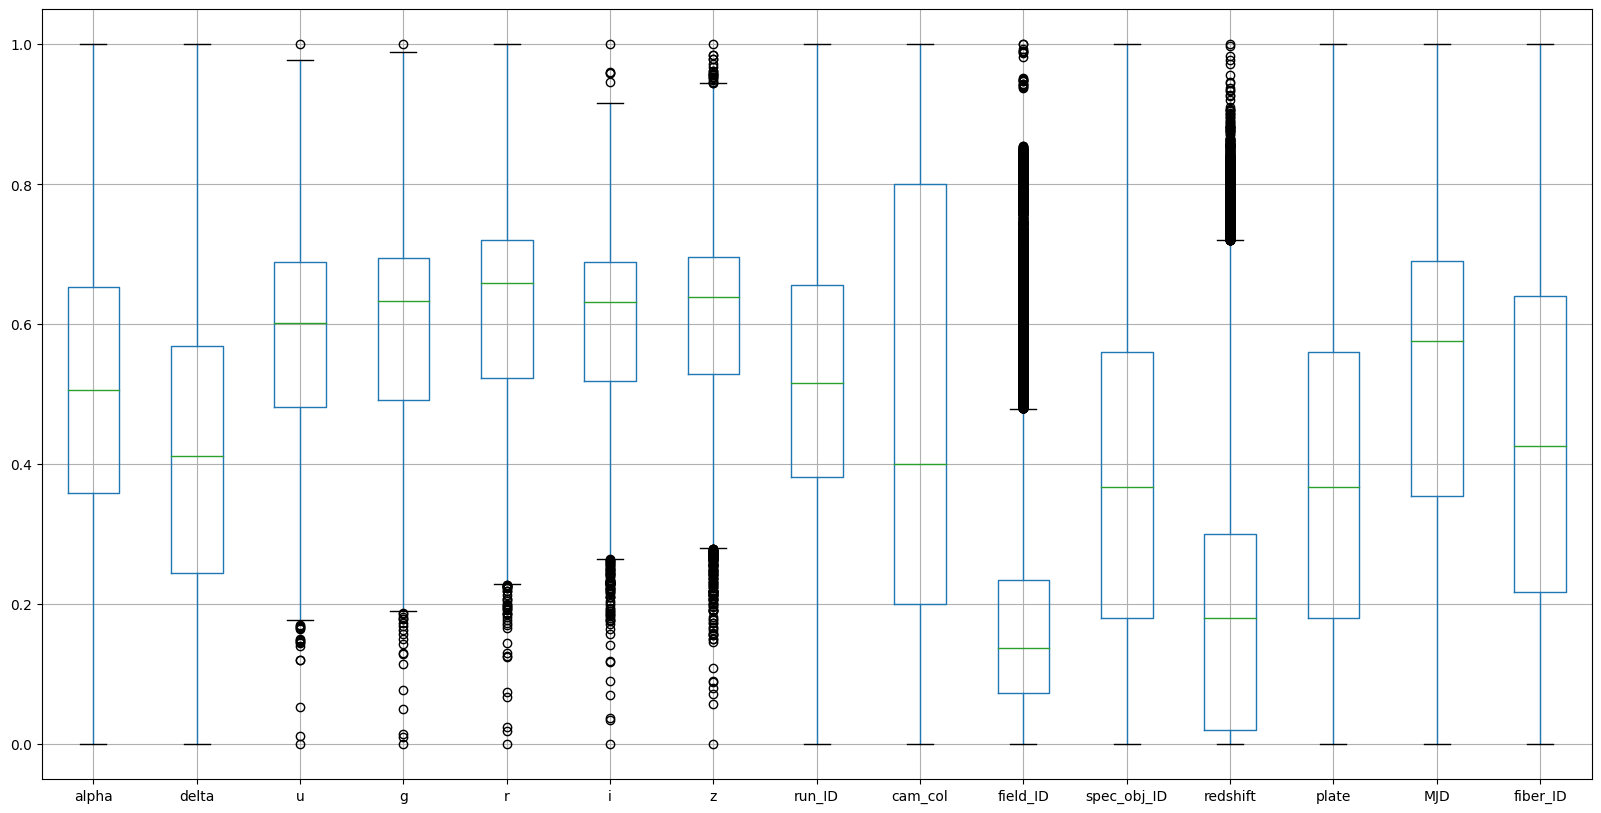

In [17]:
df_no_outliers= remove_outliers(dataframe_enc, list(dataframe_enc.columns))

df_no_outliers.boxplot(column=to_plot, figsize=(20,10))

In [18]:
model = Sequential()
model.add(Dense(15, input_shape=(15,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                240       
                                                                 
 dense_1 (Dense)             (None, 8)                 128       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


In [19]:
def my_fit(df,model,epochs=30,batch_size=32,test_size=0.2):
    target_columns = [x for x in df.columns if "class(" in x]

    X = df.drop(columns=target_columns).values
    y = df[target_columns].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=test_size)

    trained_model=deepcopy(model)

    earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True)


    history=trained_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,callbacks =[earlystopping],validation_data=(X_test,y_test))

    # _, accuracy = trained_model.evaluate(X_test, y_test)
    # print("Accuracy: %.2f" % (accuracy * 100))

    return history


In [20]:
history=my_fit(dataframe_enc,model,epochs=50)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 09:34:43         1828
metadata.json                                  2023-02-27 09:34:43           64
variables.h5                                   2023-02-27 09:34:44        14176
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 09:34:42         1828
metadata.json                                  2023-02-27 09:34:42           64
variables.h5                                   2023-02-27 09:34:44        14176
Keras weights file (<HDF5 file "variables.h

In [21]:
def plot_loss(history):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_accuracy(history):
    training_loss = history.history['accuracy']
    test_loss = history.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

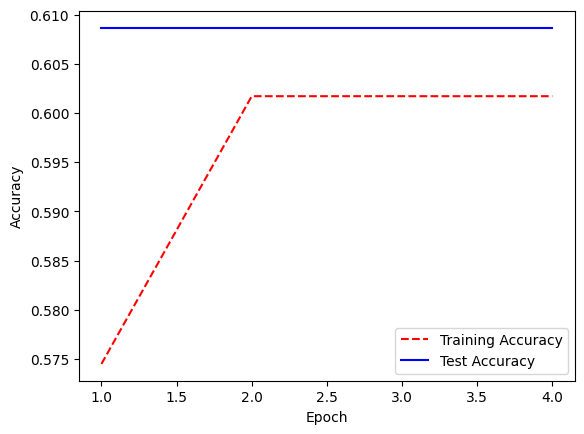

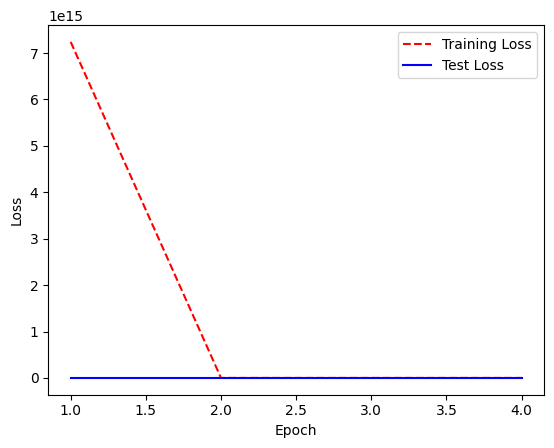

In [22]:
plot_accuracy(history)
plot_loss(history)

In [23]:
history=my_fit(df_no_outliers,model,epochs=50)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 09:34:57         1828
metadata.json                                  2023-02-27 09:34:57           64
variables.h5                                   2023-02-27 09:34:57        14176
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 09:34:56         1828
metadata.json                                  2023-02-27 09:34:56           64
variables.h5                                   2023-02-27 09:34:56        14176
Keras weights file (<HDF5 file "variables.h

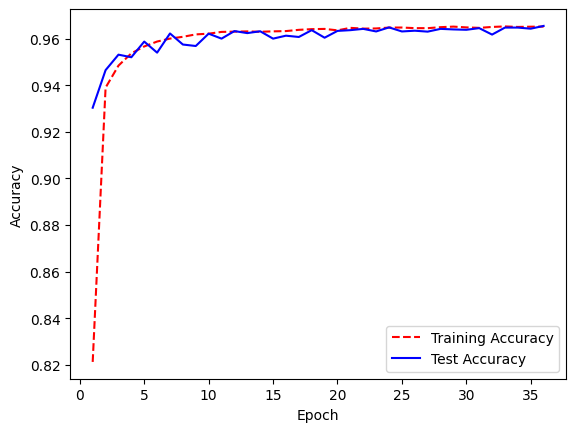

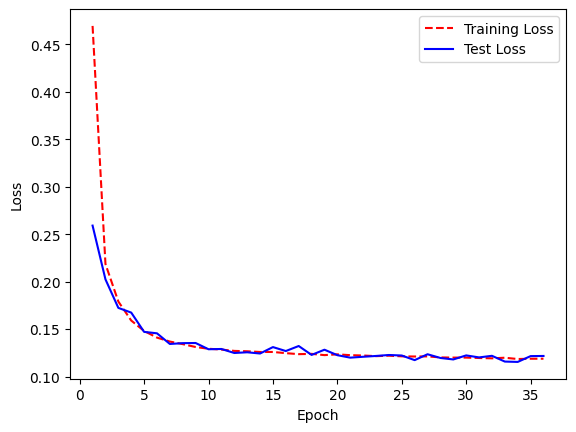

In [24]:
plot_accuracy(history)
plot_loss(history)

In [25]:
def my_overfit(df,epochs=100,batch_size=32,test_size=0.2):
    target_columns = [x for x in df.columns if "class(" in x]

    X = df.drop(columns=target_columns).values
    y = df[target_columns].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=test_size)

    trained_model = Sequential()
    trained_model.add(Dense(40, input_shape=(15,), activation='relu'))
    trained_model.add(Dense(30, activation='relu'))
    trained_model.add(Dense(20, activation='relu'))
    trained_model.add(Dense(3, activation='softmax'))

    trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    history=trained_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test))

    # _, accuracy = trained_model.evaluate(X_test, y_test)
    # print("Accuracy: %.2f" % (accuracy * 100))

    return history

history_overfit=my_overfit(df_no_outliers.iloc[:1024],batch_size=256,epochs=2000,test_size=0.2)

Epoch 1/2000
4/4 [==============================] - 1s 55ms/step - loss: 1.1207 - accuracy: 0.0879 - val_loss: 1.1018 - val_accuracy: 0.2780
Epoch 2/2000
4/4 [==============================] - 0s 10ms/step - loss: 1.0905 - accuracy: 0.4249 - val_loss: 1.0664 - val_accuracy: 0.5854
Epoch 3/2000
4/4 [==============================] - 0s 10ms/step - loss: 1.0599 - accuracy: 0.5458 - val_loss: 1.0310 - val_accuracy: 0.5317
Epoch 4/2000
4/4 [==============================] - 0s 10ms/step - loss: 1.0319 - accuracy: 0.4896 - val_loss: 0.9954 - val_accuracy: 0.5268
Epoch 5/2000
4/4 [==============================] - 0s 10ms/step - loss: 1.0028 - accuracy: 0.4908 - val_loss: 0.9609 - val_accuracy: 0.5268
Epoch 6/2000
4/4 [==============================] - 0s 10ms/step - loss: 0.9744 - accuracy: 0.4908 - val_loss: 0.9303 - val_accuracy: 0.5268
Epoch 7/2000
4/4 [==============================] - 0s 10ms/step - loss: 0.9504 - accuracy: 0.4908 - val_loss: 0.9047 - val_accuracy: 0.5268
Epoch 8/2000


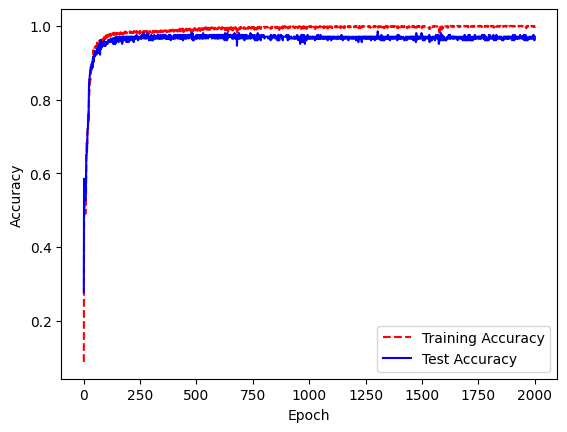

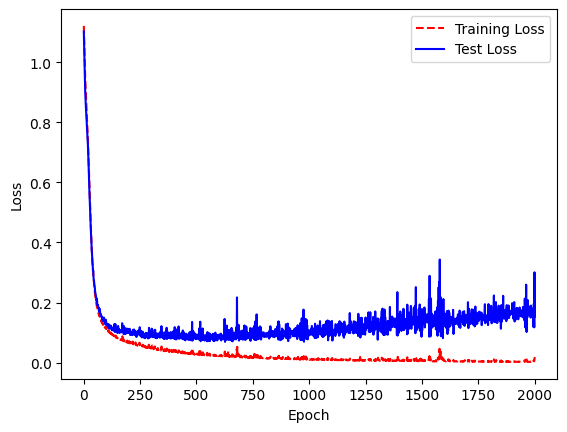

In [26]:
plot_accuracy(history_overfit)
plot_loss(history_overfit)

In [42]:
import numpy as np
from keras.callbacks import LearningRateScheduler

def my_fit_cb(df,model,epochs=30,batch_size=32,test_size=0.2,callbacks=[]):
    target_columns = [x for x in df.columns if "class(" in x]
    X = df.drop(columns=target_columns).values
    y = df[target_columns].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=test_size)
    trained_model=deepcopy(model)
    history=trained_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,callbacks =callbacks,validation_data=(X_test,y_test))
    return history


Earlystopping + dynamic learning rate

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:05:48         1828
metadata.json                                  2023-02-27 10:05:48           64
variables.h5                                   2023-02-27 10:05:48        14176
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:05:48         1828
metadata.json                                  2023-02-27 10:05:48           64
variables.h5                                   2023-02-27 10:05:48        14176
Keras weights file (<HDF5 file "variables.h

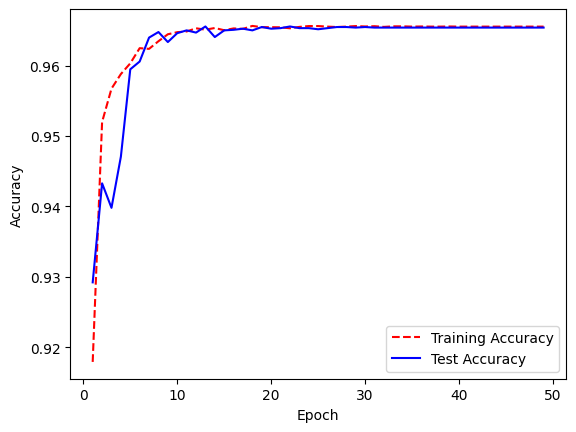

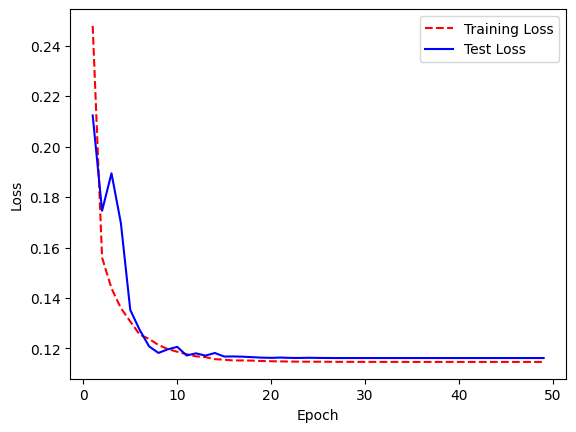

In [47]:
earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True)
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-2, decay_factor=0.75, step_size=1)

hist_lr = my_fit_cb(df_no_outliers,model,callbacks=[earlystopping, lr_sched],epochs=50)

plot_accuracy(hist_lr)
plot_loss(hist_lr)

In [48]:
import keras.backend as K

def custom_mse(y_true, y_pred):
    #Mean Squared Error
    loss = K.square(y_pred - y_true)
    loss = loss * [0.2, 0.4, 0.4]
    loss = K.sum(loss, axis=1)
    
    return loss

model_loss = Sequential()
model_loss.add(Dense(15, input_shape=(15,), activation='relu'))
model_loss.add(Dense(8, activation='relu'))
model_loss.add(Dense(3, activation='softmax'))

model_loss.compile(loss=custom_mse, optimizer='adam', metrics=['accuracy'])

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:24:53         1913
metadata.json                                  2023-02-27 10:24:53           64
variables.h5                                   2023-02-27 10:24:53        14176
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:24:52         1913
metadata.json                                  2023-02-27 10:24:52           64
variables.h5                                   2023-02-27 10:24:52        14176
Keras weights file (<HDF5 file "variables.h

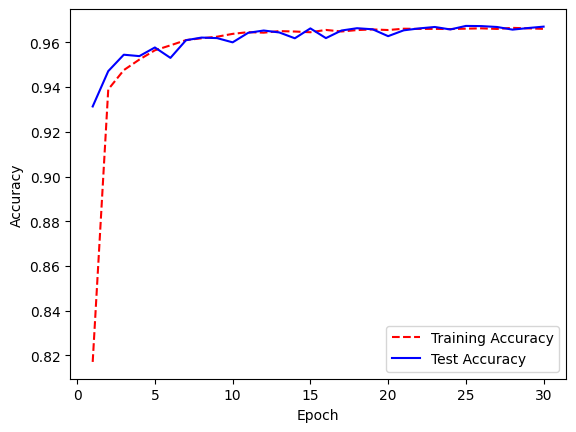

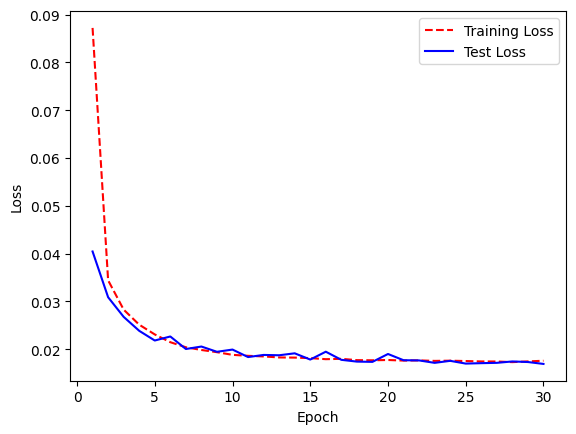

In [52]:
hist_loss = my_fit_cb(df_no_outliers,model_loss,callbacks=[],epochs=30)

plot_accuracy(hist_loss)
plot_loss(hist_loss)

In [53]:
def eval_mae(y_true, y_pred):
    #Mean Absolute Error
    eval = K.abs(y_pred - y_true)
    eval = K.mean(eval, axis=-1)
        
    return eval
  
model_eval = Sequential()
model_eval.add(Dense(15, input_shape=(15,), activation='relu'))
model_eval.add(Dense(8, activation='relu'))
model_eval.add(Dense(3, activation='softmax'))

model_eval.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[eval_mae])

In [56]:
hist_eval = my_fit_cb(df_no_outliers,model_eval,callbacks=[],epochs=30)

plot_loss(hist_eval)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:28:30         1929
metadata.json                                  2023-02-27 10:28:30           64
variables.h5                                   2023-02-27 10:28:30        14176
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 10:28:30         1929
metadata.json                                  2023-02-27 10:28:30           64
variables.h5                                   2023-02-27 10:28:30        14176
Keras weights file (<HDF5 file "variables.h

In [ ]:
training_eval = history.history['eval_mae']
test_eval = history.history['val_eval_mae']

# Create count of the number of epochs
epoch_count = range(1, len(training_eval) + 1)

# Visualize loss history
plt.plot(epoch_count, training_eval, 'r--')
plt.plot(epoch_count, test_eval, 'b-')
plt.legend(['Training Eval', 'Test Eval'])
plt.xlabel('Epoch')
plt.ylabel('Eval')
plt.show()